In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mode
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
%matplotlib inline

In [2]:
# Importing Training and test data
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

print(train_data.shape)
print(test_data.shape)

(18359, 14)
(15021, 13)


In [3]:
# Printing First Five record of training data
train_data.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,23798,city_149,0.689,Male,Has relevent experience,no_enrollment,Graduate,STEM,3,100-500,Pvt Ltd,1,106,0
1,29166,city_83,0.923,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,<10,Funded Startup,1,69,0
2,46,city_16,0.910,NaN,Has relevent experience,no_enrollment,Graduate,STEM,6,50-99,Public Sector,2,4,0
3,18527,city_64,0.666,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,50-99,Pvt Ltd,1,26,0
4,21751,city_100,0.887,NaN,No relevent experience,no_enrollment,Masters,STEM,8,NaN,NaN,2,88,1


<b>enrollee_id -> Unique ID for enrollee

city -> City code

city_development_index -> Developement index of the city (scaled)

gender -> Gender

relevent_experience -> Relevent experience

enrolled_university -> Type of University course enrolled if any

education_level -> Education level like Graduate, Masters, High Schools..

major_discipline-> Major discipline like business degree, arts, humanities

experience -> Total experience in years

company_size-> No of employees in current employer's company

company_type -> Type of current employer

last_new_job -> Difference in years between previous job and current job

training_hours -> training hours completed

target -> 0 – Not looking for job change, 1 – Looking for a job change</b>

0    15934
1     2425
Name: target, dtype: int64


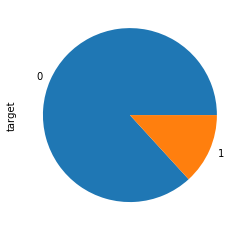

In [4]:
# Target column distribution
print(train_data["target"].value_counts())
train_data["target"].value_counts().plot(kind = "pie")
plt.show()

In [5]:
# Checking whether the enrollment id is unique 
print(train_data["enrollee_id"].nunique() == train_data.shape[0])
print(test_data["enrollee_id"].nunique() == test_data.shape[0])

True
True


In [6]:
# Checking is there any record of train data is in test data
len(train_data[train_data["enrollee_id"].isin(test_data["enrollee_id"])== True])

0

In [7]:
# Getting the Missing Values in training data
train_missing_values = pd.DataFrame(data=train_data.isnull().sum(), columns=["Missing_Values"]).sort_values(by="Missing_Values", ascending=False)
train_missing_values["Percentage"] = (train_missing_values["Missing_Values"]/train_data.shape[0])*100
train_missing_values.head(8)

,Missing_Values,Percentage
company_type,5039,27.447029
company_size,4779,26.030830
gender,4098,22.321477
major_discipline,2838,15.458358
education_level,457,2.489242
last_new_job,367,1.999020
enrolled_university,342,1.862847
experience,59,0.321368


In [8]:
# Getting the Missing Values in test data
test_missing_values = pd.DataFrame(data=test_data.isnull().sum(), columns=["Missing_Values"]).sort_values(by="Missing_Values", ascending=False)
test_missing_values["Percentage"] = (test_missing_values["Missing_Values"]/test_data.shape[0])*100
test_missing_values.head(8)

,Missing_Values,Percentage
company_type,4330,28.826310
company_size,4051,26.968910
gender,3388,22.555090
major_discipline,2393,15.931030
education_level,395,2.629652
last_new_job,304,2.023833
enrolled_university,279,1.857400
experience,44,0.292923


In [9]:
# Getting the Unique value of columns
columns = ['gender','relevent_experience', 'enrolled_university', 'education_level','major_discipline', 
           'experience', 'company_size', 'company_type','last_new_job', 'target']
for i in np.arange(len(columns)):
    print("Unique values in Column {}  is {} ".format(columns[i], train_data[columns[i]].unique()),"\n")

Unique values in Column gender  is ['Male' nan 'Female' 'Other']  

Unique values in Column relevent_experience  is ['Has relevent experience' 'No relevent experience']  

Unique values in Column enrolled_university  is ['no_enrollment' 'Full time course' 'Part time course' nan]  

Unique values in Column education_level  is ['Graduate' 'Masters' 'High School' 'Phd' nan 'Primary School']  

Unique values in Column major_discipline  is ['STEM' 'Other' 'No Major' nan 'Business Degree' 'Arts' 'Humanities']  

Unique values in Column experience  is ['3' '14' '6' '8' '>20' '4' '9' '15' '10' '1' '5' '16' '11' '12' '7' '2'
 '13' '<1' '19' '18' '17' nan '20']  

Unique values in Column company_size  is ['100-500' '<10' '50-99' nan '5000-9999' '10000+' '1000-4999' '500-999'
 '10/49']  

Unique values in Column company_type  is ['Pvt Ltd' 'Funded Startup' 'Public Sector' nan 'Early Stage Startup'
 'NGO' 'Other']  

Unique values in Column last_new_job  is ['1' '2' '3' '>4' 'never' '4' nan]  

Un

### Company_Size

In [10]:
# Treatment of column company_size
train_data["company_size"].value_counts()

50-99        3120
100-500      2698
10000+       2044
10/49        1466
1000-4999    1399
<10          1360
500-999       902
5000-9999     591
Name: company_size, dtype: int64

In [11]:
# Replacing Values in company_type
train_data["company_size"].replace({'<10':1,'10/49':2,'50-99':3,'100-500':4,'500-999':5, '1000-4999':6,'5000-9999':7,
                                   '10000+':8}, inplace= True)
test_data["company_size"].replace({'<10':1,'10/49':2,'50-99':3,'100-500':4,'500-999':5, '1000-4999':6,'5000-9999':7,
                                   '10000+':8}, inplace= True)
pd.crosstab(index=train_data["company_type"], columns=train_data["company_size"])

company_size,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0
company_type,,,,,,,,
Early Stage Startup,288,168,99,22,2,0,0,0
Funded Startup,149,208,399,226,51,0,0,0
NGO,32,33,80,183,35,77,31,41
Other,11,10,18,21,11,15,9,17
Public Sector,40,40,124,170,93,180,89,158
Pvt Ltd,775,905,2177,1916,644,1064,428,1752


In [12]:
# Filling Null Values in Company_Size column according to the mode value in Company Type Column
dict_1 = dict(train_data.groupby("company_type")["company_size"].apply(mode))

train_data["company_size"] = train_data["company_size"].fillna(value= train_data["company_type"].apply(lambda x : dict_1.get(x)))
test_data["company_size"] = test_data["company_size"].fillna(value= test_data["company_type"].apply(lambda x : dict_1.get(x)))

print(train_data["company_size"].isnull().sum())
print(test_data["company_size"].isnull().sum())

4250
3605


**There are 4250 records in training set and 3605 records in test set in which both company_size and company_type is null**

In [13]:
# Fill NA in company Size with New value 9
train_data["company_size"].fillna(9, inplace=True)
test_data["company_size"].fillna(9, inplace=True)

### Company_Type , Gender, Major_Descipline

In [14]:
# Fill NA with Unknown in Columns company_type , gender,major_descipline as they contain huge number of null values
train_data["company_type"].fillna("Unknown", inplace=True)
train_data["gender"].fillna("Unknown", inplace=True)
train_data["major_discipline"].fillna("Unknown", inplace=True)


test_data["company_type"].fillna("Unknown", inplace=True)
test_data["gender"].fillna("Unknown", inplace=True)
test_data["major_discipline"].fillna("Unknown", inplace=True)

### Last_New_Job

In [15]:
# Getting value counts of the column last_new_job
train_data["last_new_job"].value_counts().sort_index()

1        7567
2        2835
3        1027
4        1038
>4       3339
never    2186
Name: last_new_job, dtype: int64

In [16]:
train_data["last_new_job"].replace({"never":0,">4":5}, inplace=True)
test_data["last_new_job"].replace({"never":0,">4":5}, inplace=True)

train_data["last_new_job"].fillna(train_data["last_new_job"].mode()[0], inplace= True)
test_data["last_new_job"].fillna(test_data["last_new_job"].mode()[0], inplace= True)

### Enrolled_University

In [17]:
train_data["enrolled_university"] = train_data["enrolled_university"].fillna(train_data["enrolled_university"].mode()[0])
test_data["enrolled_university"] = test_data["enrolled_university"].fillna(test_data["enrolled_university"].mode()[0])

### Experience

In [18]:
# Fill NA in Experience column using model
train_data["experience"].replace({"<1":0.5,">20":21},inplace = True)
test_data["experience"].replace({"<1":0.5,">20":21},inplace = True)

train_data["experience"].fillna(train_data["experience"].mode()[0], inplace = True)
test_data["experience"].fillna(test_data["experience"].mode()[0], inplace= True)

### Education Level

In [19]:
# Fill NA in Education Level using mode
train_data["education_level"].fillna(train_data["education_level"].mode()[0], inplace=True)
test_data["education_level"].fillna(test_data["education_level"].mode()[0], inplace=True)

In [20]:
# Columns distribution
id_col = ["enrollee_id"]
cat_cols = ["city","gender","relevent_experience","enrolled_university","major_discipline","company_type","education_level"]
num_cols = ["city_development_index","experience","company_size","last_new_job","training_hours"]
target_col = ["target"]

### EDA - Numerical Columns - Univariate Analysis

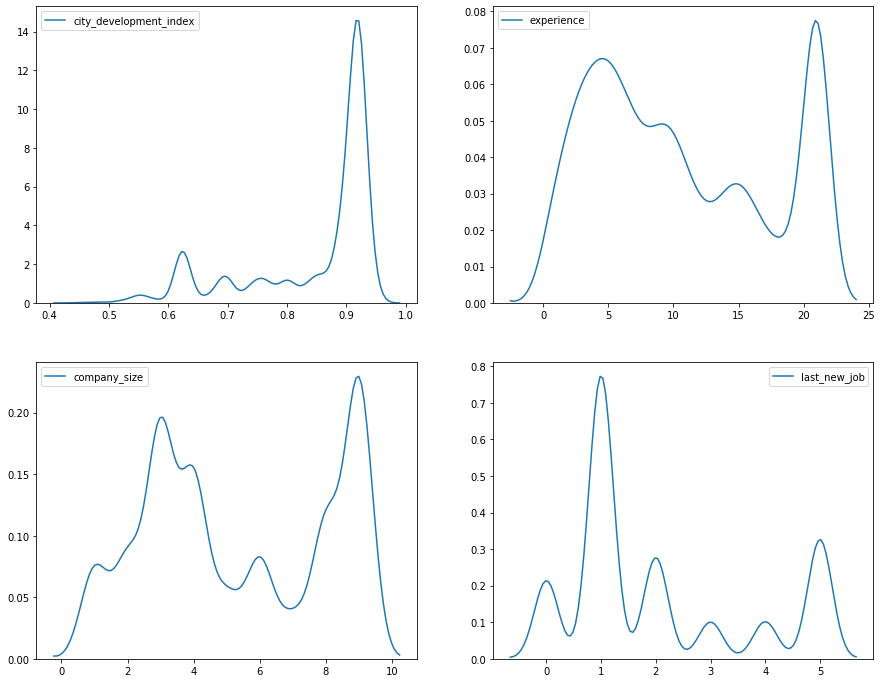

In [21]:
k = 0
fig, ax = plt.subplots(2,2, figsize=(15,12))
for i in np.arange(2):
    for j in np.arange(2):
        sns.kdeplot(train_data[num_cols[k]], ax = ax[i][j])
        k += 1

**Data is not normally distributed in any of the columns**

## Categorical Columns - Univariate Analysis

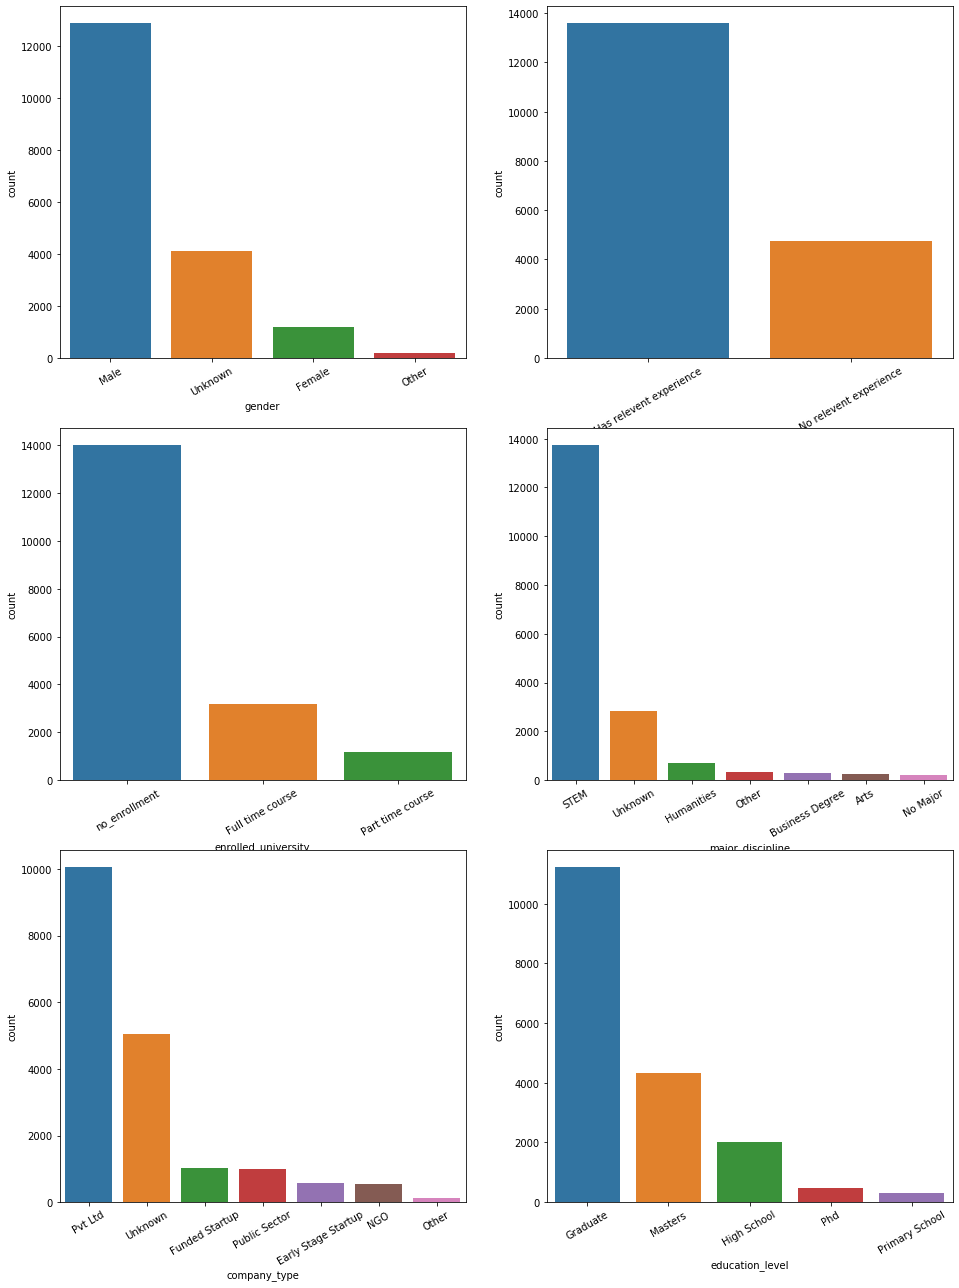

In [22]:
k = 1
fig, ax = plt.subplots(3,2, figsize=(16,22))
for i in np.arange(3):
    for j in np.arange(2):
        j = sns.countplot(x= train_data[cat_cols[k]], ax =ax[i][j], order=train_data[cat_cols[k]].value_counts().index)
        j.set_xticklabels(labels = j.get_xticklabels(),rotation = 30)
        k += 1

Number of male candidate are more than number of female candidate.Most of the Candidates are graduare working in pvt ltd company have relevent experiernce in this field.

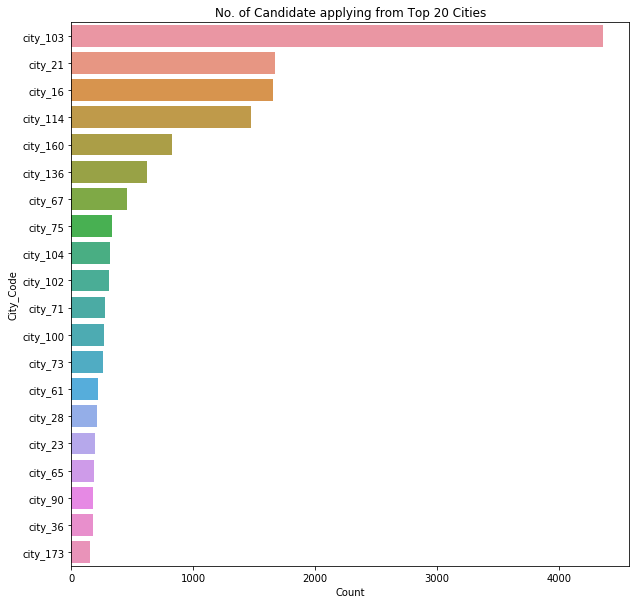

In [23]:
# Top 20 city Code
top_20_city_code = train_data["city"].value_counts().head(20).reset_index()
top_20_city_code.columns = ["City_Code", "Count"]
plt.figure(figsize = (10,10))
_ = sns.barplot(x ="Count", y ="City_Code", data=top_20_city_code)
plt.title("No. of Candidate applying from Top 20 Cities")
plt.show()

### Categorical Column with Target Column

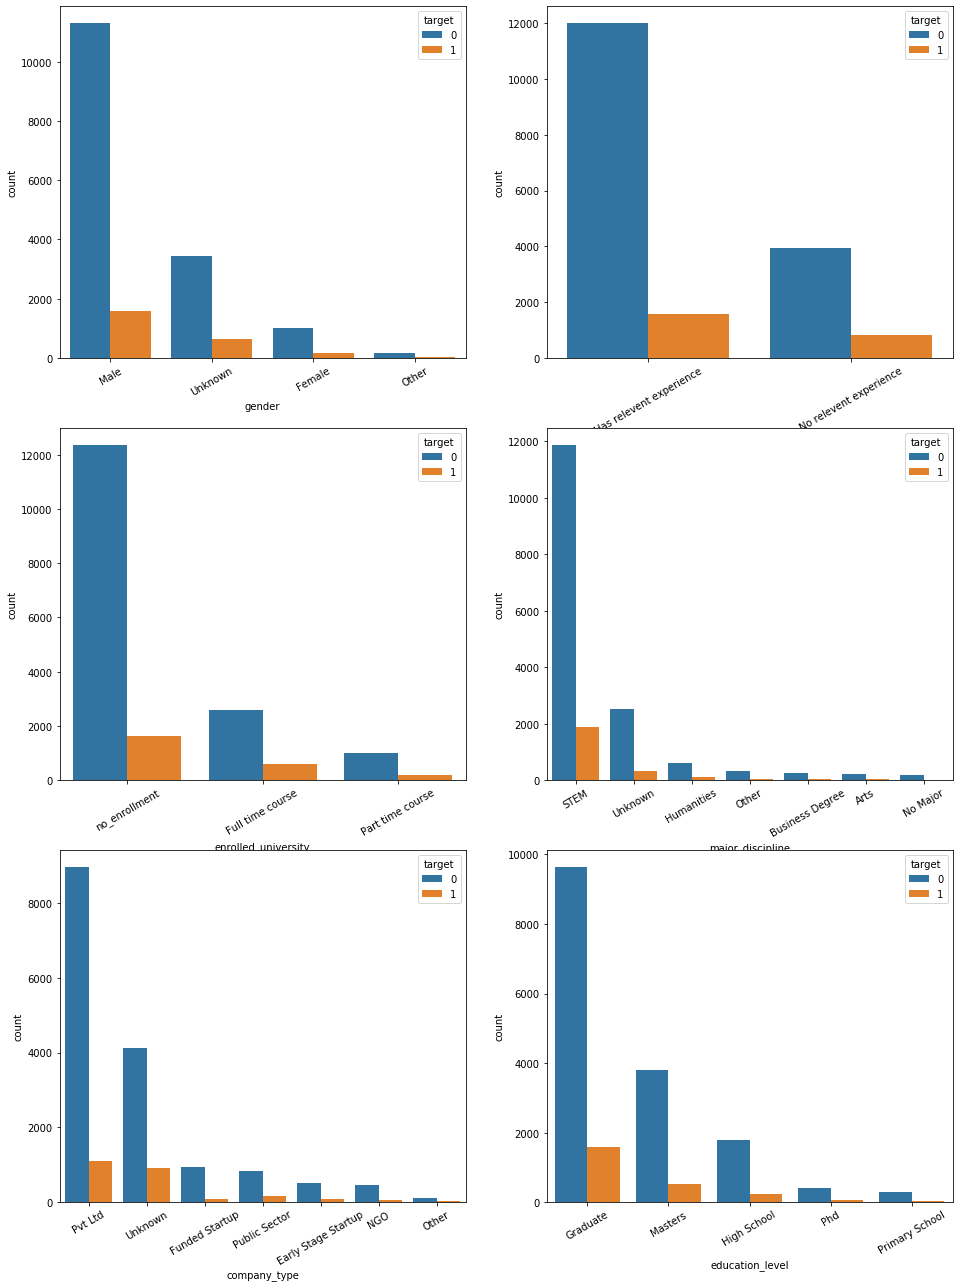

In [24]:
k = 1
fig, ax = plt.subplots(3,2, figsize=(16,22))
for i in np.arange(3):
    for j in np.arange(2):
        j = sns.countplot(x= train_data[cat_cols[k]],hue=train_data["target"], ax =ax[i][j], order=train_data[cat_cols[k]].value_counts().index)
        j.set_xticklabels(labels = j.get_xticklabels(),rotation = 30)
        k += 1

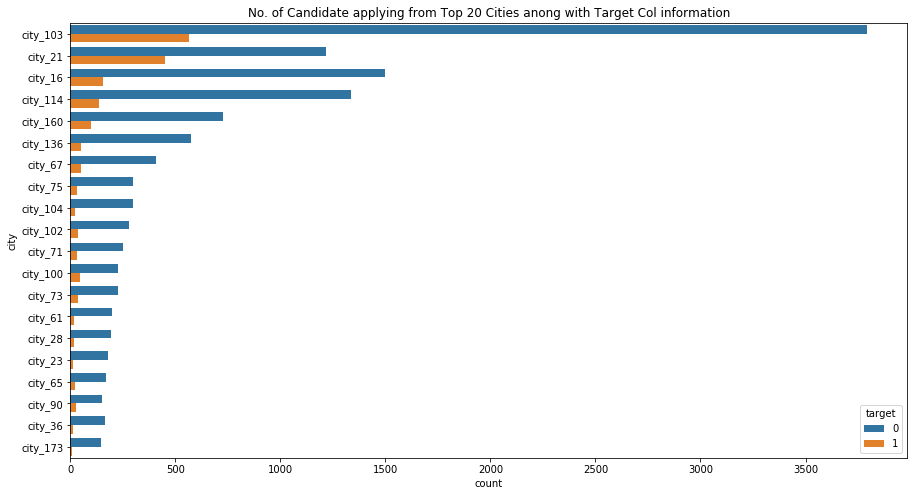

In [25]:
plt.figure(figsize=(15,8))
sample_data_1 = pd.DataFrame()
top_20_city_code = train_data["city"].value_counts().head(20).reset_index()
for code in top_20_city_code["index"]:
    sample_data = train_data[train_data["city"] == code]
    sample_data_1 = pd.concat([sample_data,sample_data_1])
sns.countplot(y = sample_data_1["city"], hue=sample_data_1["target"],order=sample_data_1["city"].value_counts().index)
plt.title("No. of Candidate applying from Top 20 Cities anong with Target Col information")
plt.show()

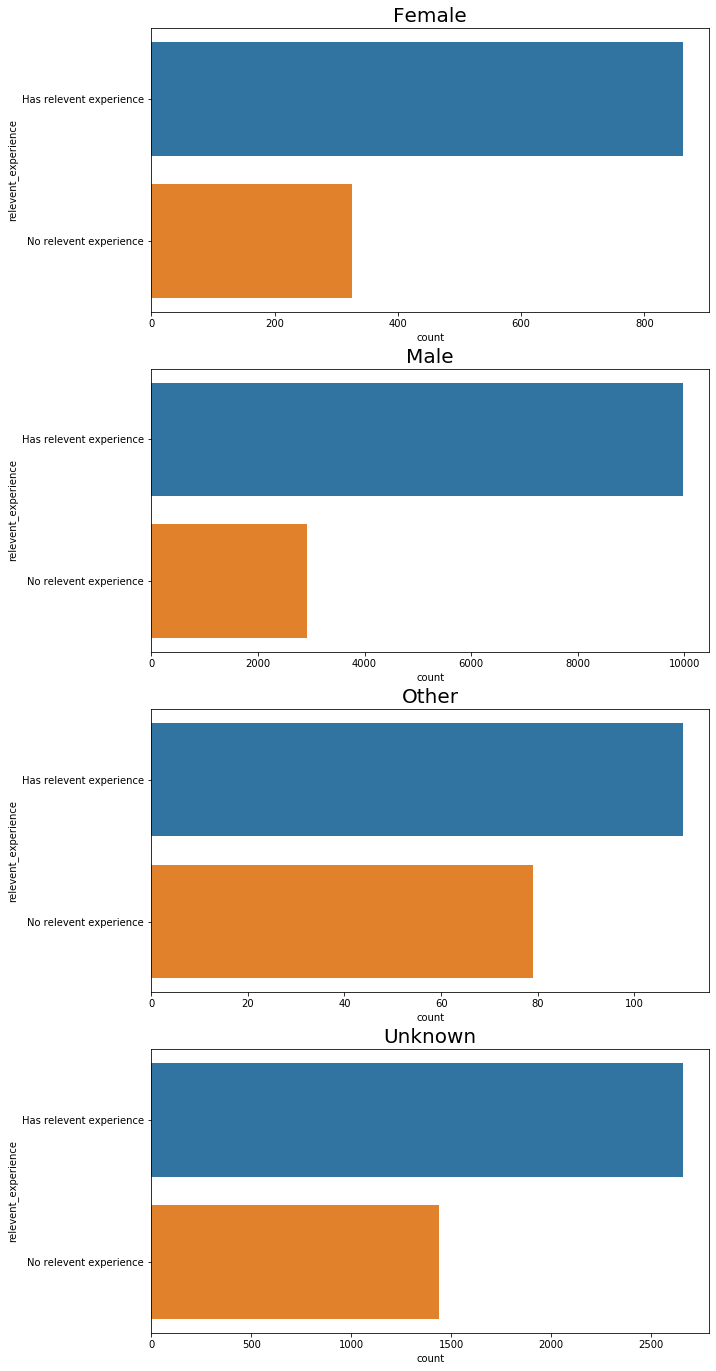

In [26]:
# Gender wise People with relevent Experience
fig, ax = plt.subplots(4,1, figsize = (10,24), squeeze=False)
for i,gender in enumerate(sorted(train_data["gender"].unique())):
    df = train_data[train_data["gender"] == gender]
    sns.countplot(y = df["relevent_experience"], ax=ax[i][0]).set_title(gender, fontsize = 20)

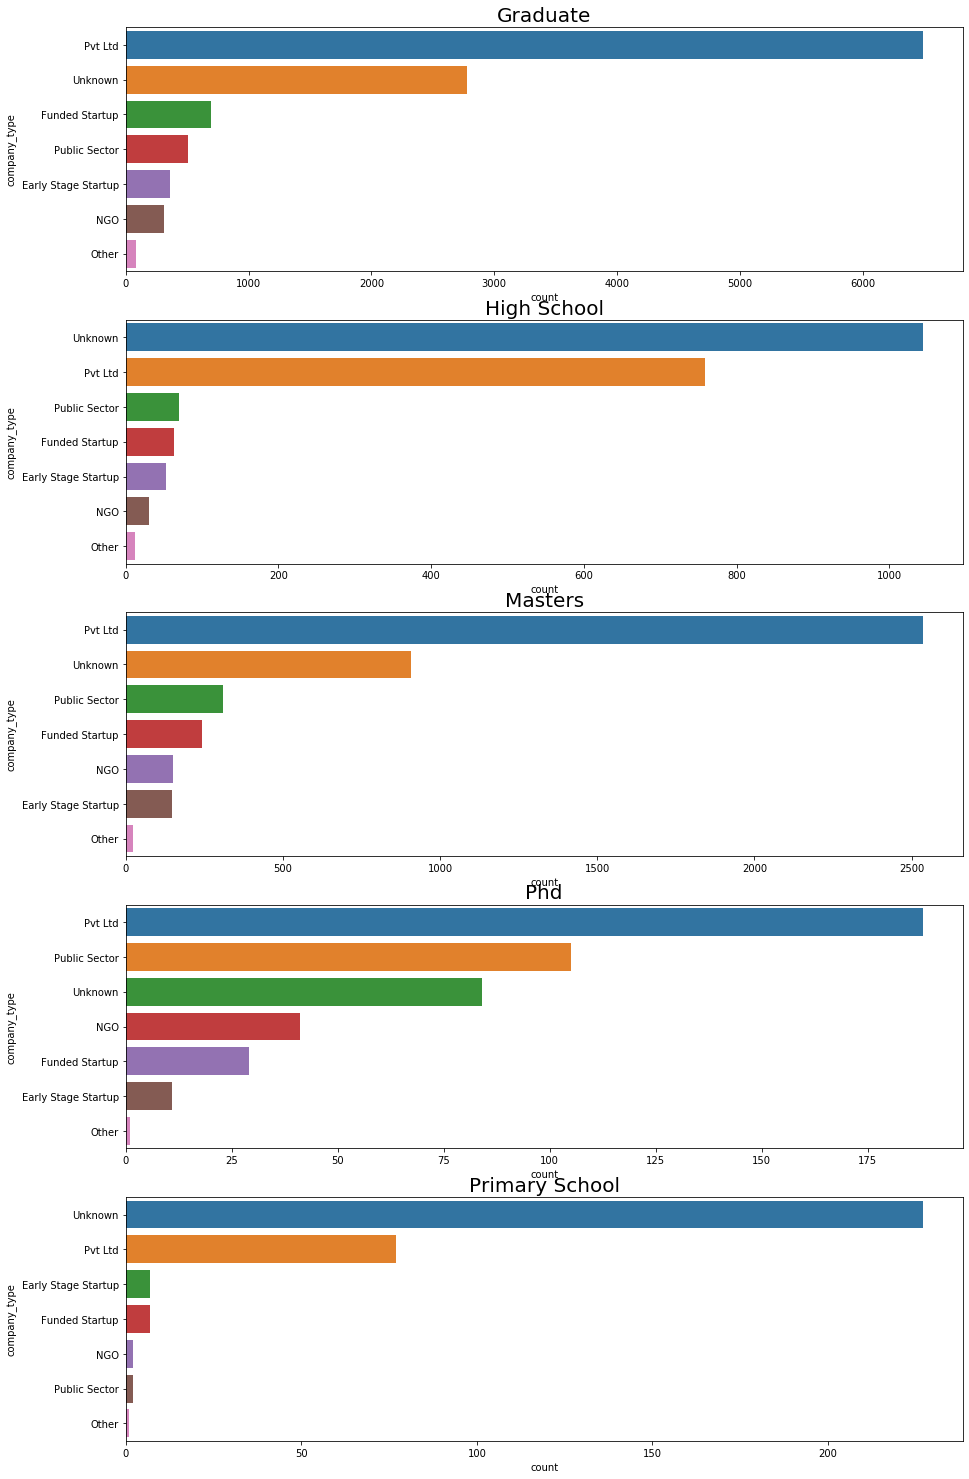

In [27]:
# Education_Level Vs Company_Type
fig, ax = plt.subplots(5,1, figsize = (15,26), squeeze=False)
for i,ed in enumerate(sorted(train_data["education_level"].unique())):
    df = train_data[train_data["education_level"] == ed]
    sns.countplot(y = df["company_type"],ax=ax[i][0], order=df["company_type"].value_counts().index).set_title(ed, fontsize = 20)

In [28]:
train_data["education_level"] = train_data["education_level"].replace({
    'Primary School' : 1,
    'High School' : 2,
    'Graduate' : 3,
    'Masters' : 4,
    'Phd' : 5,
})
test_data["education_level"] = test_data["education_level"].replace({
    'Primary School' : 1,
    'High School' : 2,
    'Graduate' : 3,
    'Masters' : 4,
    'Phd' : 5,
})


train_data["enrolled_university"].replace({"no_enrollment":0,"Part time course":1,"Full time course":2}, inplace=True)
test_data["enrolled_university"].replace({"no_enrollment":0,"Part time course":1,"Full time course":2}, inplace=True)

### City

In [29]:
train_data["city"] =train_data["city"].str.split("_").str[1].tolist()
test_data["city"] =test_data["city"].str.split("_").str[1].tolist()

### Relevent_Experience

In [30]:
train_data["relevent_experience"].replace({"Has relevent experience":1,"No relevent experience":0}, inplace= True)
test_data["relevent_experience"].replace({"Has relevent experience":1,"No relevent experience":0}, inplace= True)

In [31]:
# Label Encoding
le_gender = LabelEncoder()
le_discipline =LabelEncoder()
le_company_type = LabelEncoder()

train_data["gender"] = le_gender.fit_transform(train_data["gender"])
train_data["major_discipline"] = le_discipline.fit_transform(train_data["major_discipline"])
train_data["company_type"] = le_company_type.fit_transform(train_data["company_type"])

test_data["gender"] = le_gender.transform(test_data["gender"])
test_data["major_discipline"] = le_discipline.transform(test_data["major_discipline"])
test_data["company_type"] = le_company_type.transform(test_data["company_type"])

In [32]:
train_data.dtypes

enrollee_id                 int64
city                       object
city_development_index    float64
gender                      int32
relevent_experience         int64
enrolled_university         int64
education_level             int64
major_discipline            int32
experience                 object
company_size              float64
company_type                int32
last_new_job               object
training_hours              int64
target                      int64
dtype: object

In [33]:
# Converting DataType 
train_data["city"] = train_data["city"].astype("int")
train_data["enrolled_university"] = train_data["enrolled_university"].astype("int")
train_data["education_level"] = train_data["education_level"].astype("int")
train_data["experience"] = train_data["experience"].astype("int")
train_data["company_size"] = train_data["company_size"].astype("int")
train_data["last_new_job"] = train_data["last_new_job"].astype("int")

test_data["city"] = test_data["city"].astype("int")
test_data["enrolled_university"] = test_data["enrolled_university"].astype("int")
test_data["education_level"] = test_data["education_level"].astype("int")
test_data["experience"] = test_data["experience"].astype("int")
test_data["company_size"] = test_data["company_size"].astype("int")
test_data["last_new_job"] = test_data["last_new_job"].astype("int")

In [34]:
# Drop enrollee_id
train_data.drop(labels=["enrollee_id"], axis=1, inplace= True)
test_data.drop(labels=["enrollee_id"], axis=1, inplace= True)

In [35]:
# Feature column and Target column Split
X_train =  train_data.drop(labels=["target"], axis=1)
y_train = train_data["target"]
X_test = test_data
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

(18359, 12)
(15021, 12)
(18359,)


### CATBOOST with Stratified K Fold

In [ ]:
categorical_columns = ["city","gender","major_discipline","company_type","relevent_experience"]
fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=106)
training_score = 0
validation_score = 0
prediction_y_test = {}

for index , (train_index, validation_index) in enumerate(fold.split(X_train, y_train)):
    print("Fold ",index)
    X_train_ , X_validation = X_train.iloc[train_index] , X_train.iloc[validation_index]
    y_train_ , y_validation = y_train.iloc[train_index] , y_train.iloc[validation_index]
    
    cat_model = CatBoostClassifier(n_estimators=170, learning_rate=0.06, random_state = 106,max_depth=9,eval_metric="AUC")
    cat_model.fit(X_train_, y_train_, cat_features = categorical_columns)
    
    prediction_y_training = cat_model.predict_proba(X_train_)[:,1]
    prediction_y_validation = cat_model.predict_proba(X_validation)[:,1]
    prediction_y_test[index] = cat_model.predict_proba(X_test)[:,1]
    
    training_score += roc_auc_score(y_train_ , prediction_y_training)
    validation_score += roc_auc_score(y_validation, prediction_y_validation)

In [37]:
print("Traning Score ",training_score/5)
print("Validation Score", validation_score/5)

Traning Score  0.7440209264702398
Validation Score 0.6657300016717959


In [38]:
df = pd.DataFrame()
for i in np.arange(len(prediction_y_test)):
    df_new = pd.DataFrame(data=prediction_y_test[i])
    df = pd.concat([df, df_new], axis=1)
df.columns = [1,2,3,4,5]
df["Mean"] = (df[1] + df[2] + df[3] + df[4] + df[5]) / 5

In [39]:
sample_submission = pd.read_csv("sample_submission.csv", index_col=None)
sample_submission["target"] = df["Mean"]
sample_submission.to_csv("sample_submission.csv", index= None)

**Accuracy on Test set is 68.279**